In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot') #Make the graphs pretty :) 

In [2]:
#Load data:

df = pd.DataFrame.from_csv('sonar.all-data',index_col=None)
#Create columns list. EB stands for Energy band
cols = ['EB'+str(i) for i in range(1,len(df.columns))] + ['Class']
df.columns = cols

# Part B. data description:


The data contains patterns of sonar projected upon cylindircal rocks, and cylndrical metal objects.
The data includes 207 samples, and 60 features. Each feature represents the energy in a different energy band, each row represents a different experiment (measurement - the sonar returned from the object). The data also includes the class (rock vs metal) for each experiment.

In [3]:
#General stats of the data:
df.describe().loc[['mean','std','max']]


,EB1,EB2,EB3,EB4,EB5,EB6,EB7,EB8,EB9,EB10,...,EB51,EB52,EB53,EB54,EB55,EB56,EB57,EB58,EB59,EB60
mean,0.029208,0.038443,0.043837,0.054053,0.075105,0.104599,0.121591,0.134677,0.177361,0.208245,...,0.016034,0.013472,0.010729,0.010917,0.009300,0.008181,0.007771,0.007947,0.007936,0.006523
std,0.023038,0.033040,0.038521,0.046583,0.055669,0.059247,0.061897,0.085340,0.118311,0.134741,...,0.012027,0.009628,0.007071,0.007310,0.007103,0.005719,0.005756,0.006485,0.006196,0.005038
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


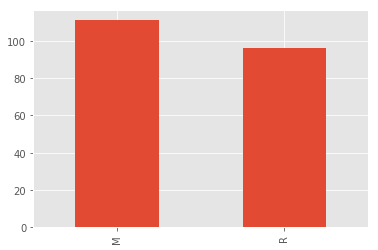

In [4]:
#Labels distribution
sr = df['Class']

sr.value_counts().plot(kind='bar')


As we can see, there is a simillar number of samples of each class (R/M). Approximately 90~ each (there are slightly more samples of metal).

**Statistics of each class:**

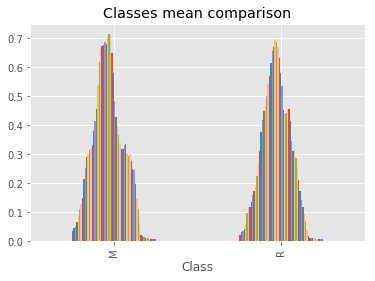

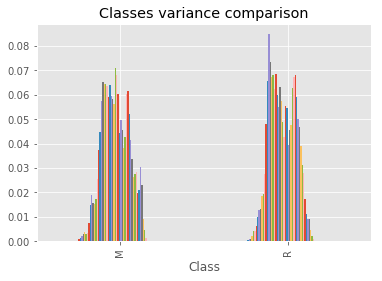

In [5]:
classDf =  df.groupby('Class')
classDf.mean().plot(kind='bar',legend=False,title='Classes mean comparison')
classDf.var().plot(kind='bar',legend=False,title='Classes variance comparison')


As we can see, it seems that the average is simillar between the classes, but the variance shows higher difference.

# Part C: Compute the PCA
**We shall use simillar methods to those we've seen in the tutorial.
For efficiancy purposes, we will compute the eigenvectors/values by ourselves (as we would need a different number of them each iteration). 

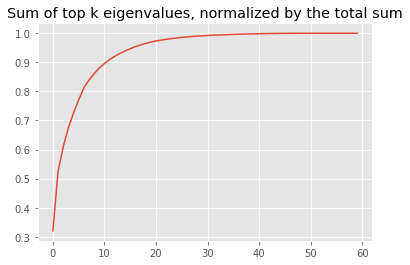

In [6]:
#Substract means, and calc cov matrix.
#From the recitation:

X = df.iloc[:,:-1].values
X = X.T
mean_vec = np.mean(X, axis=1)
X_zero_mean = (X.T-mean_vec).T

cov_mat = X_zero_mean.dot(X_zero_mean.T) / (X.shape[1]-1)

#Calculate eigenvalues/vectors, and sort them in decreasing order.

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(reverse=True)


#Let us recall that the sum of eigenvalues is the variance. 
#Hence, lets visualize the ratio between the eigenvlaues: 
tot = sum(eig_vals)
var_exp = [(i / tot) for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.plot(cum_var_exp) 
plt.title('Sum of top k eigenvalues, normalized by the total sum')
plt.show()



**As we can see, after approximately the top 25 eigenvlaues, the contribution of the remaining becomes almost insignificant. Let us demonstrate it with the gradient as well:**

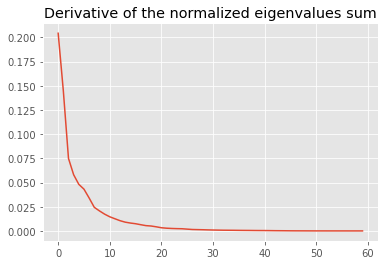

In [7]:
cumSumGradient = np.gradient(cum_var_exp)
plt.plot(cumSumGradient)
plt.title('Derivative of the normalized eigenvalues sum')

plt.show()

**As we can see, the derivative tends towards 0, hence no significant contribution to the total sum/variance**

In [8]:
#Now, after we've computed the eigenvectors and values, let us project our data into 2/3 dimentional subspace.
W2d = eig_vecs[:,0:2]
W3d = eig_vecs[:,0:3]

#After we've calculated the transformation matrices, let us compute the projected data.

X2d = W2d.T.dot(X)
X3d = W3d.T.dot(X)

#As expected, the new shapes of X are (dim,No* of samples) - in our case (2/3,207)
print ('The dimentions of X2d are: {}. The dimensions of X3d are: {}'.format(X2d.shape,X3d.shape))




The dimentions of X2d are: (2, 207). The dimensions of X3d are: (3, 207)


# Part D: visualization

# Part E: Compute the error curve

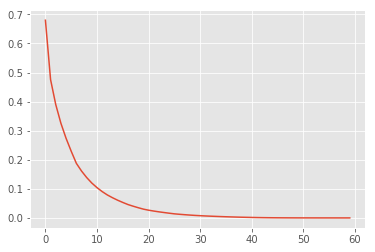

In [9]:
#Let us compute the reconstruction error:
X_norm = np.linalg.norm(X_zero_mean,ord='fro')
error = []
for i in range(len(eig_vals),0,-1):
    W = eig_vecs[:,0:i]
#     print(W)
    diff = ((np.linalg.pinv(W)).T).dot((W.T).dot(X_zero_mean))-X_zero_mean
    error.append(np.square(np.linalg.norm(diff,ord='fro')/X_norm))

error = error[::-1]

plt.plot(error)


**Simillarly to our conclusions from the eigenvalues graphs, here we can see that the error remains almost the same after about ~30 eigenvalues are being taken.**

# Part F: Determain how many vectors are required for sufficient reconstruction.

In [13]:
def getVecNum(errorArr,sucess): #Return the minimal number of eigen vectors, required for a certain error level.
    error = 1- sucess
    for idx,val in enumerate(errorArr):
        if val < error:
            return idx
        
    return None #No suitable value was found.

for i in [0.95,0.99]:
    print ('The number of vectors required for {} sucess rate is {} '.format(i,getVecNum(error,i)))

        

0 0.679962836733
1 0.475623684594
2 0.390133303147
3 0.325674269781
4 0.273991116838
5 0.229361656091
6 0.187648818058
7 0.161235466634
8 0.138850128232
9 0.11982839017
10 0.104150977831
11 0.090602279915
12 0.0790112940391
13 0.0694872957408
14 0.0608943715612
15 0.0532068446482
16 0.0460172108298
The number of vectors required for 0.95 sucess rate is 16 
0 0.679962836733
1 0.475623684594
2 0.390133303147
3 0.325674269781
4 0.273991116838
5 0.229361656091
6 0.187648818058
7 0.161235466634
8 0.138850128232
9 0.11982839017
10 0.104150977831
11 0.090602279915
12 0.0790112940391
13 0.0694872957408
14 0.0608943715612
15 0.0532068446482
16 0.0460172108298
17 0.040339585852
18 0.0350650444454
19 0.0301848097554
20 0.0265474337236
21 0.0236034396529
22 0.0209153422673
23 0.0185204642031
24 0.0161912142344
25 0.0140281092766
26 0.0124830203419
27 0.0110739307708
28 0.00978074366956
The number of vectors required for 0.99 sucess rate is 28 
